In [ ]:
!python -m pip install -r requirements.txt

#  SectionSeeker - Seismic Image finder Starter Notebook

**This notebook and package has been adapted from ThinkOnward's [Reflection Connection Challenge](https://thinkonward.com/app/c/challenges/reflection-connection), which ran in late 2023. The SectionSeeker can be used to train a SiameseNN to identify similar sections to the one a user inputs. This can be extremely useful for seismic interpreters looking for an analog section or basin.**

In [1]:
# add the following paths to use modules we prepared for you
import sys

ROOT = "."  # project root directory
sys.path.append(f"{ROOT}/SectionSeeker")
sys.path.append(f"{ROOT}/SectionSeeker/snn")

### Data

🚨 To [download the data](https://huggingface.co/datasets/thinkonward/reflection-connection) and the models ([B-16](https://huggingface.co/thinkonward/section-seeker-base-16) or [L-16](https://huggingface.co/thinkonward/section-seeker-large-16)) you will need a [HuggingFace account](https://huggingface.co/) and request data and model access.

To make sure that data can be accessed by this notebook unpack archives containing train and test data into `ROOT/data/` directory.

The data for this challange consists of four parts:

1. Training set (`data/train`) of 561 images, divided in 8 distinct categories 
2. Validation set (`data/test`) of 105 images, divided in 8 distinct categories 
3. Image corpus (`data/image_corpus`) of 362 unlabeled images with unknown category.
4. Query set (`data/query`) of 50 unlabeled images with unknown category

Each image is a 1-channel, 2D patch cut out from multiple sections of 3D seismic volumes. 

Training and validation set both contain labeled images. Dataset has a structure similar to well-known MNIST dataset - images are stored in subcatalogs that represent class labels. Both training and validation data can be accessed with `SeismicDataset` class that offers an API very similar to a standard MNIST torch vision dataset.

Classes in the dataset are as follows:

1. `Boring` - No visible interesting features
2. `Bright_Planar` - Contains laterally continuous bright seismic amplitudes
3. `Bright_Chaotic` - Contains chaotic bright amplitudes
4. `Channel` - Visible channels (irrespective of depositional environment)
5. `Converging_Amplitudes` - Seismic amplitudes that converge together
7. `Fault` - Visible faults offsetting seismic horizons
8. `Salt` - Visible salt body which may contain the top or edge of the salt body
9. `Transparent_Planar` - Patches where the seismic reflectors are planar and the majority of the reflectors are transparent

The split between test and train was arbitrary to demonstrate capabilities of the tools available to you in this challange - you are free to move patches between the test and train sets. Keep in mind that class `Boring` contains only patches of uninteresting seismic - we will not ask you to find images that belong to this class in the image corpus.

Image corpus and query contain sets of unlabeled images that can be accessed with the `ImageSet` class. 
**You must not use this data in training of the model**. 

Note that some of images in image corpus and query set don't belong to any category defined within training and validation sets and will be used to evaluate performance of your algorithm in one-shot scenario.

**Your ultimate goal is to prepare an algorithm that will search through image corpus to find 3 most similar images for each patch in query set**.


Download the dataset to your machine after requesting access from HuggingFace

In [2]:
import huggingface_hub

huggingface_hub.login()

In [3]:
DATA_REPO_ID = "thinkonward/reflection-connection"
huggingface_hub.snapshot_download(
    repo_id=DATA_REPO_ID, repo_type="dataset", local_dir="./data"
)

Fetching 709 files:   0%|          | 0/709 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

aczgx.png:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

aoord.png:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

amtqn.png:   0%|          | 0.00/9.28k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.32k [00:00<?, ?B/s]

bacnt.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

bobqs.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

axkpq.png:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

bztqu.png:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

cypbk.png:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

cyvmv.png:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

duuce.png:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

dqusm.png:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

druas.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

dilfz.png:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

dyfjv.png:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

evfkm.png:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

fatax.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

frebw.png:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

ftgsk.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

ghxop.png:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

gdqra.png:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

gdddd.png:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

gjzbf.png:   0%|          | 0.00/9.62k [00:00<?, ?B/s]

gkdcz.png:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

dfquc.png:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

gqjcs.png:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

gymtn.png:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

hpzpi.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

hltcq.png:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

hnzkw.png:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

hsbqt.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

hzsdg.png:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

hzpml.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

iboti.png:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

jqoel.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

jicdt.png:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

jfqqr.png:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

kcrci.png:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

kkbul.png:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

jhkxm.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

kzpqe.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

kajhl.png:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

lftpk.png:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

lsqfx.png:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

kzuuj.png:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

lmqor.png:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

muodd.png:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

lwswb.png:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

lljfv.png:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

mxcyl.png:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

nokyy.png:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

nwgwo.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

oiohf.png:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

ooaav.png:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

odlgb.png:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

ofusu.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

obdyy.png:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

ouakr.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

odirc.png:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

ouivw.png:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

pdigu.png:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

pmtfj.png:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

prqau.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

prnfq.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

pvmcz.png:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

pvydw.png:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

qgaqz.png:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

qawor.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

qjgjj.png:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

qqdjq.png:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

rponj.png:   0%|          | 0.00/18.7k [00:00<?, ?B/s]

tffbk.png:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

sknty.png:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

qzgnv.png:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

tesdi.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

sbpih.png:   0%|          | 0.00/9.36k [00:00<?, ?B/s]

tvsqf.png:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

uqkmp.png:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

uuuzn.png:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

vdctq.png:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

viihy.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

vmhje.png:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

vzcjf.png:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

wtcqz.png:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

wjkdu.png:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

vdqqb.png:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

wttsx.png:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

wameh.png:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

xhvrg.png:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

xiugj.png:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

xbkio.png:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

xoerq.png:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

yhllr.png:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

zjffk.png:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

ytivk.png:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

zmbzo.png:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

zolkh.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

zwbgs.png:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

ztgqp.png:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

zxsoj.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

zwjjm.png:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

aogst.png:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

bbqxg.png:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

eckdo.png:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

cwrzg.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

dbxmq.png:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

engqt.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

fhnts.png:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

hqfll.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

gdchp.png:   0%|          | 0.00/32.1k [00:00<?, ?B/s]

ezuen.png:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

iiqot.png:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

ijdzo.png:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

itzis.png:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

jggsc.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

iyphf.png:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

klxxh.png:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

jjvxo.png:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

iwiev.png:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

lvoiu.png:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

kthks.png:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

nfnmb.png:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

lzwdh.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

ngxvb.png:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

nojtp.png:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

miufj.png:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

mfros.png:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

mzwjh.png:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

pijkw.png:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

qsiio.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

qemqk.png:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

skjpp.png:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

sjplt.png:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

uciie.png:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

skqhg.png:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

siisg.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

qtudi.png:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

uyjad.png:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

ukwfg.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

vcnst.png:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

wvbsi.png:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

yjglq.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

yzaxb.png:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

yracw.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

xvhbx.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

wtdvm.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

wakcc.png:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

zivsv.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

zjxrd.png:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

zluym.png:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

rc.png:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

zqqan.png:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

bapif.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

bfvcs.png:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

axmqi.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

crzdd.png:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

cscli.png:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

bycwu.png:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

eloyb.png:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

eiukk.png:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

etckt.png:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

ewqup.png:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

flzyt.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

fingp.png:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

hmfij.png:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

gugeq.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

iafbj.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

ihzgr.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

mwtnv.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

gtsoa.png:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

nztjt.png:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

nrcsj.png:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

oflqt.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

npnbr.png:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

rrjcf.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

qpuna.png:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

jcexq.png:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

ptuwg.png:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

vcpqm.png:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

xpkkn.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

umtth.png:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

yalyq.png:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

luqem.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

qjidg.png:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

oldfo.png:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

cseng.png:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

wngod.png:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

cguak.png:   0%|          | 0.00/9.76k [00:00<?, ?B/s]

cszlx.png:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

eogbz.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

fcapa.png:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

npxve.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

habim.png:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

hboqz.png:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

stfpp.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

udywe.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

nfdis.png:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

qqedc.png:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

queqw.png:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

rknmq.png:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

veyrp.png:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

tbxmd.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

wuibt.png:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

yuysg.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

zghgx.png:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

aczhc.png:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

xhmvz.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

yzuwt.png:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

lrlgc.png:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

mllfl.png:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

dauab.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

qwnyk.png:   0%|          | 0.00/9.27k [00:00<?, ?B/s]

qnfma.png:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

simtj.png:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

rhkiq.png:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

psktg.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

yiwxa.png:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

aqxqh.png:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

bglkg.png:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

mtumw.png:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

knfjq.png:   0%|          | 0.00/38.3k [00:00<?, ?B/s]

cxfcm.png:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

ezais.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

oftxx.png:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

qqvns.png:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

dqwmb.png:   0%|          | 0.00/21.4k [00:00<?, ?B/s]

qwjfp.png:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

rpqps.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

rbiyw.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

rhmnx.png:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

whwpg.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

voitc.png:   0%|          | 0.00/23.5k [00:00<?, ?B/s]

rskdq.png:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

vkwsv.png:   0%|          | 0.00/22.6k [00:00<?, ?B/s]

zrkau.png:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

xrtfa.png:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

ctuib.png:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

iihff.png:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

dwlzw.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

hftpe.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

mrjdf.png:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

kgvuk.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

qvgro.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

uwnfm.png:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

ayqya.png:   0%|          | 0.00/11.0k [00:00<?, ?B/s]

uyxjv.png:   0%|          | 0.00/19.6k [00:00<?, ?B/s]

biytn.png:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

bofgn.png:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

vvurv.png:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

bwbag.png:   0%|          | 0.00/9.07k [00:00<?, ?B/s]

eojzc.png:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

mbmcs.png:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

mxlua.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

swoto.png:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

jzxsu.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

whqha.png:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

abwao.png:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

ayfuk.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

chuli.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

zyzkp.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

cdhjj.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

blkcv.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

bjtqd.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

cfljo.png:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

crsba.png:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

cwlxa.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

dgyzz.png:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

dzads.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

enupk.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

ckwgc.png:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

dbfbw.png:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

dwdyw.png:   0%|          | 0.00/21.6k [00:00<?, ?B/s]

erdnu.png:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

gmyjt.png:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

gpaln.png:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

gyyyg.png:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

fomcc.png:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

gvaob.png:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

fqeqx.png:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

hhvof.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

hpgol.png:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

ieslf.png:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

iriyx.png:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

irewh.png:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

ietpa.png:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

inbpm.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

huqqo.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

jicxi.png:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

kjhak.png:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

klylr.png:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

kzpgy.png:   0%|          | 0.00/21.7k [00:00<?, ?B/s]

jrhui.png:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

lpzml.png:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

ltqjc.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

lqitx.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

kjmwb.png:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

luagv.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

lvdrn.png:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

mdhgu.png:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

nipjm.png:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

njcxx.png:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

mfooq.png:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

mdrco.png:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

lubgd.png:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

nokmk.png:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

nrrik.png:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

nsxkv.png:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

ojchs.png:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

nzzcp.png:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

orlqm.png:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

orwat.png:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

pcqcc.png:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

pgexp.png:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

pntjh.png:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

qbaqg.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

qiofx.png:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

pxhuw.png:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

ptnub.png:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

qidsu.png:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

qitgc.png:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

qwwpp.png:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

reszq.png:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

rfqlb.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

riftf.png:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

sdxml.png:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

saiji.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

srahu.png:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

rvixf.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

tadyh.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

snhmf.png:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

tmbuk.png:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

terii.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

upvxz.png:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

vidvt.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

uskbx.png:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

tnqvp.png:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

upyyt.png:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

vwsuc.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

vimxb.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

vjzxd.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

wcllq.png:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

wooch.png:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

xducx.png:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

xhfvq.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

xgwui.png:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

xjnhk.png:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

xmspp.png:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

xkndu.png:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

xwxrr.png:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

xxkmv.png:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

yfptw.png:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

yqpbg.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

yfczt.png:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

ytuft.png:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

xiuxh.png:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

bupih.png:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

byqli.png:   0%|          | 0.00/8.90k [00:00<?, ?B/s]

yyzfd.png:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

atocs.png:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

erjcc.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

dfjtv.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

yqsna.png:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

fbxef.png:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

fgoim.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

gftxo.png:   0%|          | 0.00/29.6k [00:00<?, ?B/s]

hygvu.png:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

nrcok.png:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

iwhyu.png:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

hhjqu.png:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

nooei.png:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

qmxgf.png:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

pwelo.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

rvrmp.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

ssftf.png:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

sjnmm.png:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

vlclt.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

tnnbh.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

wpkuy.png:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

srznz.png:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

srnii.png:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

wwoas.png:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

zunxu.png:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

ajoub.png:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

aymwj.png:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

akytm.png:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

bamib.png:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

bszgg.png:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

awwcz.png:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

crjgd.png:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

ctigj.png:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

eaekn.png:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

cybud.png:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

ewdck.png:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

dxvxt.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

dvett.png:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

fivfg.png:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

fmeyh.png:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

hbdvq.png:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

hgosg.png:   0%|          | 0.00/9.03k [00:00<?, ?B/s]

hvhgh.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

kfudw.png:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

jceai.png:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

lqhjr.png:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

ibuay.png:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

nbjwz.png:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

ntqaj.png:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

nizmy.png:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

nzgec.png:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

oaszv.png:   0%|          | 0.00/14.9k [00:00<?, ?B/s]

tkxek.png:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

oljfy.png:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

oraee.png:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

qrflk.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

twjus.png:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

ujffg.png:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

vhkkn.png:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

yhomm.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

abipn.png:   0%|          | 0.00/33.2k [00:00<?, ?B/s]

zqmpq.png:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

yiisj.png:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

acbop.png:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

ailnc.png:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

bwifd.png:   0%|          | 0.00/28.5k [00:00<?, ?B/s]

awvzv.png:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

cacmo.png:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

dkdnz.png:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

hatug.png:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

hqmbn.png:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

cdfir.png:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

fmmrg.png:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

jplro.png:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

ifnqd.png:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

kbfnm.png:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

lknyc.png:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

naqeo.png:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

jpmhy.png:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

ncawe.png:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

myxoa.png:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

nhxxa.png:   0%|          | 0.00/35.1k [00:00<?, ?B/s]

nfkoy.png:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

okgww.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

oilux.png:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

nwcbd.png:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

onoca.png:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

orncv.png:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

pwjrt.png:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

pagzu.png:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

qjztk.png:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

przgc.png:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

pzpia.png:   0%|          | 0.00/29.6k [00:00<?, ?B/s]

prcoc.png:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

qizzx.png:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

tukji.png:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

qqari.png:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

vrltr.png:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

qtual.png:   0%|          | 0.00/28.8k [00:00<?, ?B/s]

wfftt.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

wuely.png:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

umbvl.png:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

xxmpc.png:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

yggop.png:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

dxhoo.png:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

bppwj.png:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

ygvxh.png:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

eraaq.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

cnuyw.png:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

ceefd.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

ervui.png:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

euugv.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

fefbd.png:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

fzubn.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

ftpaf.png:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

ezudx.png:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

fusrs.png:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

exajh.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

evtsx.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

gtizq.png:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

hlkxy.png:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

iewcs.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

kazvl.png:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

irjzm.png:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

kftgd.png:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

kajga.png:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

ikjkm.png:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

krkfm.png:   0%|          | 0.00/9.49k [00:00<?, ?B/s]

lmikh.png:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

llnjf.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

luiol.png:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

nbxvs.png:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

mdtvf.png:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pqgwn.png:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

nidbm.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

nyhyx.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

qdxvd.png:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

qwpdx.png:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

qprgj.png:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

txosr.png:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

sssyc.png:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

ssacm.png:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

soder.png:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

umzaq.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

vdzqw.png:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

usgyy.png:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

ylpdc.png:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

uzwpw.png:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

zpzyn.png:   0%|          | 0.00/30.0k [00:00<?, ?B/s]

aihol.png:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

abhkh.png:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

azkkv.png:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

baryc.png:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

bcwbb.png:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

bfjbq.png:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

buinb.png:   0%|          | 0.00/34.0k [00:00<?, ?B/s]

bypzf.png:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

bvmkj.png:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

bzxzx.png:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

byzgu.png:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

cansc.png:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

bmzsi.png:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

cfbex.png:   0%|          | 0.00/20.0k [00:00<?, ?B/s]

clnsr.png:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

ctfxs.png:   0%|          | 0.00/23.7k [00:00<?, ?B/s]

dzcpy.png:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

drbab.png:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

fbxbn.png:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

cezxp.png:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

cwntn.png:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

fpfbd.png:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

fgepq.png:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

ftkls.png:   0%|          | 0.00/23.8k [00:00<?, ?B/s]

hbmah.png:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

hifgn.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

gmrbe.png:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

gzwak.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

gknml.png:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

gckai.png:   0%|          | 0.00/24.1k [00:00<?, ?B/s]

hkdki.png:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

hsqgq.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

ifnwv.png:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

ixour.png:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

jjzlt.png:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

iwgku.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

iknzt.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

jwosi.png:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

koxhk.png:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

lhtcn.png:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

kqdvq.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

lfjik.png:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

kqfaq.png:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

kpbrq.png:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

menzv.png:   0%|          | 0.00/20.3k [00:00<?, ?B/s]

lrakf.png:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

mfheg.png:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

mfyor.png:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

mpoqp.png:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

mjqqw.png:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

msfmd.png:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

mzkxl.png:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

mukcq.png:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

nxmgr.png:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

ndvsg.png:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

nzxed.png:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

ofsbc.png:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

oggtl.png:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

pcxfg.png:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

orvxr.png:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

puyrd.png:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

qfeoh.png:   0%|          | 0.00/23.8k [00:00<?, ?B/s]

qophx.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

rkkaj.png:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

rnxmg.png:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

rncgb.png:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

rofvv.png:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

smfus.png:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

symbi.png:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

tfsgh.png:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

rmhqx.png:   0%|          | 0.00/17.3k [00:00<?, ?B/s]

tsegh.png:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

uddfa.png:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

tyicd.png:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

tqjpo.png:   0%|          | 0.00/26.3k [00:00<?, ?B/s]

stboq.png:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

ujhuf.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

uupvq.png:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

uqoes.png:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

vlijs.png:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

vqbue.png:   0%|          | 0.00/31.3k [00:00<?, ?B/s]

vudfa.png:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

vqchl.png:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

viscx.png:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

uwvni.png:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

vztac.png:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

vuqhn.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

vxxce.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

wscui.png:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

wqnce.png:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

wwbjx.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

xduwo.png:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

xemnc.png:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

xdgir.png:   0%|          | 0.00/15.5k [00:00<?, ?B/s]

xgchz.png:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

xohoz.png:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

zqtuk.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

zxngb.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

zgueu.png:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

axvpj.png:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

btvbb.png:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

aywjf.png:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

cxwvk.png:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

zmggo.png:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

dsvhv.png:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

dujmk.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

dxtxf.png:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

gsaop.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

dzvbw.png:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

eaecn.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

gzitc.png:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

hqjrl.png:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

hrzam.png:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

irjdc.png:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

jcznx.png:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

mttxn.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

mjyuj.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

kapmv.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

mfgxx.png:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

lyeht.png:   0%|          | 0.00/9.18k [00:00<?, ?B/s]

nsxdz.png:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

mpyfg.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

nigxb.png:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

nultv.png:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

okfgy.png:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

opxxj.png:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

rgivw.png:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

ozjtk.png:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

qyiik.png:   0%|          | 0.00/16.4k [00:00<?, ?B/s]

rgvbr.png:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

nyxxg.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

rzyex.png:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

slxrr.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

sbdyu.png:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

uwuyn.png:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

synpb.png:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

rkvpk.png:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

tqcia.png:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

xejhc.png:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

vzbik.png:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

wykbe.png:   0%|          | 0.00/17.4k [00:00<?, ?B/s]

bpsjc.png:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

crybb.png:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

xkfcw.png:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

zoful.png:   0%|          | 0.00/19.0k [00:00<?, ?B/s]

bjrso.png:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

dgjrm.png:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

dpnpd.png:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

dgckn.png:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

eoytm.png:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

dysuz.png:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

fuypy.png:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

dxkel.png:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

gdocv.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

fugoq.png:   0%|          | 0.00/9.01k [00:00<?, ?B/s]

fduwb.png:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

ggzyu.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

gjcmh.png:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

gnhyj.png:   0%|          | 0.00/25.2k [00:00<?, ?B/s]

gpxpz.png:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

hhryi.png:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

iibdm.png:   0%|          | 0.00/8.86k [00:00<?, ?B/s]

gqyww.png:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

iaevo.png:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

jeylb.png:   0%|          | 0.00/24.3k [00:00<?, ?B/s]

iyfbq.png:   0%|          | 0.00/9.29k [00:00<?, ?B/s]

itvox.png:   0%|          | 0.00/12.1k [00:00<?, ?B/s]

jpnnc.png:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

khrpi.png:   0%|          | 0.00/15.3k [00:00<?, ?B/s]

klbno.png:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

kbstb.png:   0%|          | 0.00/9.53k [00:00<?, ?B/s]

lbqtx.png:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

jujcp.png:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

kuxze.png:   0%|          | 0.00/8.11k [00:00<?, ?B/s]

ksrec.png:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

lhcfs.png:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

nnqmi.png:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

mobjx.png:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

ludmc.png:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

nsddd.png:   0%|          | 0.00/9.77k [00:00<?, ?B/s]

nnjaa.png:   0%|          | 0.00/9.34k [00:00<?, ?B/s]

offyn.png:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

nxfcg.png:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

nyexn.png:   0%|          | 0.00/9.60k [00:00<?, ?B/s]

qplho.png:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

pdawn.png:   0%|          | 0.00/9.80k [00:00<?, ?B/s]

oyhvi.png:   0%|          | 0.00/9.42k [00:00<?, ?B/s]

pmepy.png:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

pqdbx.png:   0%|          | 0.00/9.51k [00:00<?, ?B/s]

rbcui.png:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

rhmhf.png:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

qdxno.png:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

tkhri.png:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

rogzr.png:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

shzrn.png:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

uzmjq.png:   0%|          | 0.00/7.73k [00:00<?, ?B/s]

srktr.png:   0%|          | 0.00/16.8k [00:00<?, ?B/s]

wpjxe.png:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

skxvn.png:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

vllae.png:   0%|          | 0.00/26.2k [00:00<?, ?B/s]

zflij.png:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

zuvzz.png:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

'/home/ec2-user/SageMaker/section-seeker/data'

In [4]:
import numpy as np
import skimage

from matplotlib import pyplot as plt
from albumentations.augmentations.geometric.transforms import PadIfNeeded
import albumentations as A
import cv2
from PIL import Image
from typing import Callable, Union
from torch import Tensor
import torchvision.transforms as T

from SectionSeeker.snn.dataset.dataset import SeismicDataset
from SectionSeeker.snn.dataset.wrappers import ContrastiveDataset, TripletDataset

%matplotlib inline

Let's start with creating SeismicDataset on top of training data
You specify `build=True` to build the dataset directly from images instead of loading the tensor file. 
You can create the tensor file from dataset by calling `dataset.save()` method

In [5]:
# transformation to pad images before passing to ViT. Supports standard and compatibility mode
def vit_transform(img: Union[Tensor, Image.Image]) -> Tensor:

    pad = PadIfNeeded(224, 224, value=-1, border_mode=cv2.BORDER_CONSTANT)
    if isinstance(img, Image.Image):
        transformed_img = pad(image=np.array(img)).get("image")
    elif isinstance(img, Tensor):
        transformed_img = pad(image=img.numpy()).get("image")
    else:
        transformed_img = pad(image=img).get("image")

    return Tensor(transformed_img)


# Specify compatibilty_mode=True to support storing and getting data as PIL Images
# Note that image-wise normalization is enabled bu default. Specify normalize=False to disable it
dataset = SeismicDataset(
    ROOT, build=True, greyscale=False, train=True, transform=vit_transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


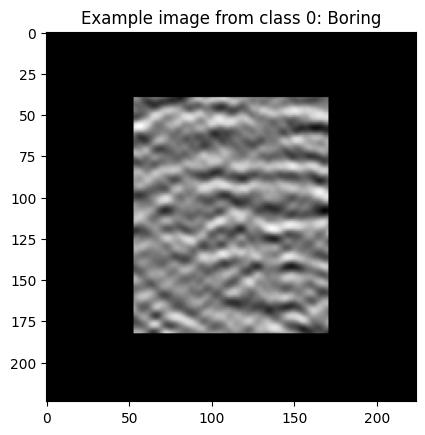

In [6]:
# each item of dataset is a tuple of image tensor with shape HxWxC and integer label. You can access names of classes with dataset.classes
idx = 0
plt.imshow(dataset[idx][0].numpy())
plt.title(
    f"Example image from class {dataset[idx][1]}: {dataset.classes[dataset[idx][1]]}"
)
# Warnings are only caused by floating-point error
plt.show()

As a next step you create an instance of ContrastiveDataset built on top of training seismic dataset
Contrastive dataset builds pairs of images with binary target, indicating whether both images come from the same class

Default mode for contrastive dataset is `train`, in which `__getitem__` method will generate random pairs for the indexed element of the seismic dataset each time it's called (lazy generation). In `test` mode, on the other hand, pairs are generated during contstruction of the dataset (eager generation), and therefeore are fixed. This behaviour is ment to make sure that validation scores depend only on model performance, not random pair selection. Same approach was also used in other type of dataset - `TripletDataset`, which will be discussed later

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


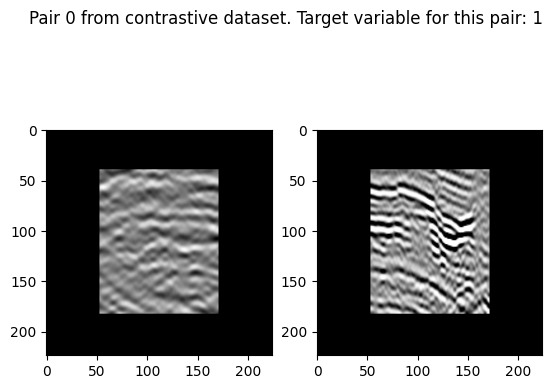

In [7]:
contrastive_dataset = ContrastiveDataset(dataset)

# Each item of the contrastive dataset is a tuple of (HxWxC image 1 tensor, CxHxW image 2 tensor) and a binary target variable
idx = 0

fig, ax = plt.subplots(1, 2)
ax[0].imshow(contrastive_dataset[idx][0][0].numpy().transpose(1, 2, 0))
ax[1].imshow(contrastive_dataset[idx][0][1].numpy().transpose(1, 2, 0))

fig.suptitle(
    f"Pair {idx} from contrastive dataset. Target variable for this pair: {contrastive_dataset[idx][1]}"
)
# Warnings are only caused by floating-point error
plt.show()

Siamese neural networks can be trained in many ways - using `ContrastiveDataset` to create pairs annotated with target variable is only one of them. Other possible approach is to use `TripletDataset`, that creates triplets of anchor image, positive reference (same class) and negative reference (other class). You can build it on top of `SeismicDataset` in a same way that you used for `ContrastiveDataset`

Note that for compatibility reasons, each item of TripletDataset is a tuple of (HxWxC anchor image tensor, CxHxW posititive image tensor, CxHxW negative image tensor) and empty list: `((Tensor, Tensor, Tensor), [])`


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


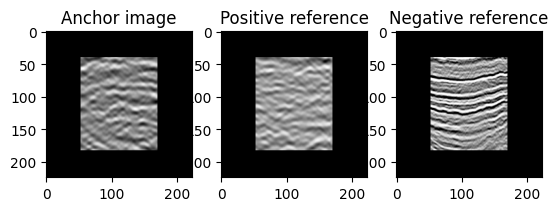

In [8]:
triplet_dataset = TripletDataset(dataset)

idx = 0

fig, ax = plt.subplots(1, 3)
ax[0].imshow(triplet_dataset[idx][0][0].numpy().transpose(1, 2, 0))
ax[0].set_title("Anchor image")
ax[1].imshow(triplet_dataset[idx][0][1].numpy().transpose(1, 2, 0))
ax[1].set_title("Positive reference")
ax[2].imshow(triplet_dataset[idx][0][2].numpy().transpose(1, 2, 0))
ax[2].set_title("Negative reference")

# Warnings are only caused by floating-point error
plt.show()

The order in which you serve pairs or triplets for training Siamese Neural Networks might have a huge impact on model performance. You might want to modify `ContrastiveDataset` or `TripletDataset` wrappers to use better pair matching algorithm than just random selection. Check the original FaceNet paper for more information https://arxiv.org/pdf/1503.03832.pdf

# Example Solution

## Model overview

Problem of learning on dataset with sparse labels is generally refered to as few-shot learning. Special case of few-shot learning is one-shot learning, when you ask the model to make predictions for the new class, that was not present in training set and it's seen by the model for the first time as a query image during inference. 

Since you want to be able to use reference images to query the model for matching pairs - we decided to use Siamese Neural Network architecture with pre-trained ResNet-50 backbone. We encourage you to explore different architectures, backbone models and training procedures to achieve best performance not only in the few-shot problem, but also generalize well enough to maintain perfomance also in one-shot scenario.

## Training

There are many possible approaches to train Siamesese Neural Networks. Most popular strategies include:
1. Using binary classifier with standard BCE loss as the last stage of network. This is efficient for simple problems, like classification on MNIST dataset
2. Using Contrastive Loss to push embeddings for different classes as far from each other as possible in latent space
3. Using Triplet loss to separate embeddings in latent space without additional target variable, using anchor image instead. This was the approach used in FaceNet, achieving SOTA performance in facial recognition.

We provide you with all above losses and corresponding datasets to choose the best training approach. In this example we used Contrastive loss to train the Siamese NN. We decided to separate training in two stages - first stage is meant to obtain initial convergence, while second stage with very small batch size is supposed to improve performance in one-shot image recognition.

In [9]:
import torch
from torch import nn

from SectionSeeker.snn.losses import ContrastiveLoss
from SectionSeeker.snn.model import SiameseNetwork
from SectionSeeker.snn.train import Trainer
from SectionSeeker.snn.config import ModelConfig

You will need to now download the model weights from the HuggingFace repositories. To do this you need a HuggingFace account and to request model access.

In [10]:
B16_MODEL_REPO_ID = "thinkonward/section-seeker-base-16"
huggingface_hub.snapshot_download(
    repo_id=B16_MODEL_REPO_ID,
    repo_type="model",
    local_dir="./b_16_checkpoint",
    allow_patterns="*.pth",
)

L16_MODEL_REPO_ID = "thinkonward/section-seeker-large-16"
huggingface_hub.snapshot_download(
    repo_id=L16_MODEL_REPO_ID,
    repo_type="model",
    local_dir="./l_16_checkpoint",
    allow_patterns="*.pth",
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ViT_B_16_SEISMIC31K.pth:   0%|          | 0.00/346M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ViT_L_16_SEISMIC31K.pth:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

'/home/ec2-user/SageMaker/section-seeker/l_16_checkpoint'

In [11]:
# specify configurations for local checkpoints
# Note that the `SiameseNetwork()` constructor will first try to load model weights from Torchvision.
# It will only proceed to loading local checkpoint when the first attempt fails
# For models that have `fc.in_features` attribute you can specify FC_IN_FEATURES=0 for automatic detection

vitBConfigPretrained = ModelConfig(
    BACKBONE_MODEL="ViT_B_16",
    BACKBONE_MODEL_WEIGHTS="./b_16_checkpoint/ViT_B_16_SEISMIC31K.pth",
    LATENT_SPACE_DIM=16,
    FC_IN_FEATURES=768,
)

vitLConfigPretrained = ModelConfig(
    BACKBONE_MODEL="ViT_L_16",
    BACKBONE_MODEL_WEIGHTS="./l_16_checkpoint/ViT_L_16_SEISMIC31K.pth",
    LATENT_SPACE_DIM=16,
    FC_IN_FEATURES=1024,
)

In [12]:
cuda = torch.cuda.is_available()
device = torch.device("cuda") if cuda else torch.device("cpu")
model = SiameseNetwork(vitLConfigPretrained)
# we recommend freezing pretrained & fine-tuned backbone at least in the first stage of training SNN
model.freeze_backbone()

Initialized weights for fully connected component


### First stage of training 

In [13]:
kwargs = {"num_workers": 4, "pin_memory": True} if cuda else {}
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    contrastive_dataset, batch_size=batch_size, shuffle=True, **kwargs
)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)
n_epochs = 10
contrastive_loss = ContrastiveLoss()

In [14]:
siamese_trainer = Trainer("contrastive", optimizer, cuda, log_interval=100)

In [15]:
siamese_trainer.train(model, train_loader, scheduler, n_epochs=n_epochs)

Train Epoch: 0 [0/451 (0%)]	Loss: 0.226895
Train Epoch: 1 [0/451 (0%)]	Loss: 0.106775
Train Epoch: 2 [0/451 (0%)]	Loss: 0.148337
Train Epoch: 3 [0/451 (0%)]	Loss: 0.138462
Train Epoch: 4 [0/451 (0%)]	Loss: 0.136163
Train Epoch: 5 [0/451 (0%)]	Loss: 0.074675
Train Epoch: 6 [0/451 (0%)]	Loss: 0.107291
Train Epoch: 7 [0/451 (0%)]	Loss: 0.103328
Train Epoch: 8 [0/451 (0%)]	Loss: 0.105465
Train Epoch: 9 [0/451 (0%)]	Loss: 0.177218


### Second stage of training

In [16]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(
    contrastive_dataset, batch_size=batch_size, shuffle=True, **kwargs
)
n_epochs = 20

In [17]:
siamese_trainer.train(model, train_loader, scheduler, n_epochs=n_epochs)

Train Epoch: 0 [0/451 (0%)]	Loss: 0.105039
Train Epoch: 0 [200/451 (44%)]	Loss: 0.069229
Train Epoch: 0 [400/451 (88%)]	Loss: 0.168055
Train Epoch: 1 [0/451 (0%)]	Loss: 0.113765
Train Epoch: 1 [200/451 (44%)]	Loss: 0.085873
Train Epoch: 1 [400/451 (88%)]	Loss: 0.206194
Train Epoch: 2 [0/451 (0%)]	Loss: 0.113211
Train Epoch: 2 [200/451 (44%)]	Loss: 0.278147
Train Epoch: 2 [400/451 (88%)]	Loss: 0.176493
Train Epoch: 3 [0/451 (0%)]	Loss: 0.094507
Train Epoch: 3 [200/451 (44%)]	Loss: 0.148441
Train Epoch: 3 [400/451 (88%)]	Loss: 0.037308
Train Epoch: 4 [0/451 (0%)]	Loss: 0.073663
Train Epoch: 4 [200/451 (44%)]	Loss: 0.066304
Train Epoch: 4 [400/451 (88%)]	Loss: 0.082733
Train Epoch: 5 [0/451 (0%)]	Loss: 0.072768
Train Epoch: 5 [200/451 (44%)]	Loss: 0.041371
Train Epoch: 5 [400/451 (88%)]	Loss: 0.068085
Train Epoch: 6 [0/451 (0%)]	Loss: 0.045705
Train Epoch: 6 [200/451 (44%)]	Loss: 0.130626
Train Epoch: 6 [400/451 (88%)]	Loss: 0.030041
Train Epoch: 7 [0/451 (0%)]	Loss: 0.028792
Train Epoch:

### Evaluation of network performance

To evaluate the performance of the embedding network you can simply compare distances in latent space between positive and negative pairs. In a well-trained model, average distance for positive pairs should be considerably smaller than for negative pairs. Bigger differences indicate better separation between embeddings of different classes, leading to better overall performance

In [18]:
from snn.utils import all_pairs, contrative_distances
from snn.predict import predict_embeddings

In [19]:
val_dataset = SeismicDataset(
    ROOT, build=True, greyscale=False, train=False, transform=vit_transform
)

In [20]:
val_contrastive_dataset = ContrastiveDataset(val_dataset)

In [21]:
embeddings = predict_embeddings(model, val_dataset, return_labels=True)

In [22]:
embedding_pairs = all_pairs(embeddings)

In [23]:
distances = contrative_distances(embedding_pairs)

In [24]:
print(
    f"""Average distance between negative pairs: {np.array(distances[0]).mean():.3f},
Average distance between positive pairs: {np.array(distances[1]).mean():.3f}"""
)

Average distance between negative pairs: 0.646,
Average distance between positive pairs: 0.394


## Semantic search across image corpus

The ultimate goal of the challange is to find patches belonging to the same object class as the reference image in an image corpus - set of multiple patches, most of which don't contain any distinct patterns (they belong to the "Boring" class). To find 3 most similar images for each reference you next search for nearest neighbors in k-d tree build on latent representations of each image

In [25]:
from search import ImageSet, SearchTree

In [26]:
# Note that image-wise normalization is enabled bu default. Specify normalize=False to disable it
corpus = ImageSet(ROOT, build=True, transform=vit_transform).build_embeddings(model)
query_set = ImageSet(
    ROOT, build=True, base=False, transform=vit_transform
).build_embeddings(model)

In [27]:
tree = SearchTree(corpus)

Building KD-Tree from embeddings


In [28]:
reference_labels, distances, _, matched_labels = tree(query_set)

Now that you have the reference labels, distances, and matched labels you can visualize the sections and see how well the model did.

In [29]:
import cv2
import matplotlib.pyplot as plt


def display_images(reference_labels, matched_labels, ref_img_number):
    # Number of images to display per row
    num_images_per_row = 4

    # Create subplots
    f, axarr = plt.subplots(1, num_images_per_row, figsize=(20, 5))

    # Function to load and resize an image
    def load_and_resize_image(path):
        img = cv2.imread(path)
        if img is None:
            print(f"Failed to load {path}")
            return np.zeros(
                (100, 100, 3), dtype=np.uint8
            )  # Return a black image if loading fails
        return cv2.resize(img, (100, 100))

    # Display reference image
    axarr[0].imshow(
        load_and_resize_image("data/query/" + reference_labels[ref_img_number])
    )
    axarr[0].set_title("Reference")
    axarr[0].axis("off")

    # Display matched images
    for i in range(1, num_images_per_row):
        if i < len(matched_labels):
            axarr[i].imshow(
                load_and_resize_image(
                    "data/image_corpus/" + matched_labels[ref_img_number][i - 1]
                )
            )
            axarr[i].set_title(
                "Matched distance: " + str(round(distances[ref_img_number][i - 1], 2))
            )
            axarr[i].axis("off")
        else:
            # Fill remaining space with blank images
            axarr[i].imshow(np.zeros((100, 100, 3), dtype=np.uint8))
            axarr[i].axis("off")

    plt.tight_layout()

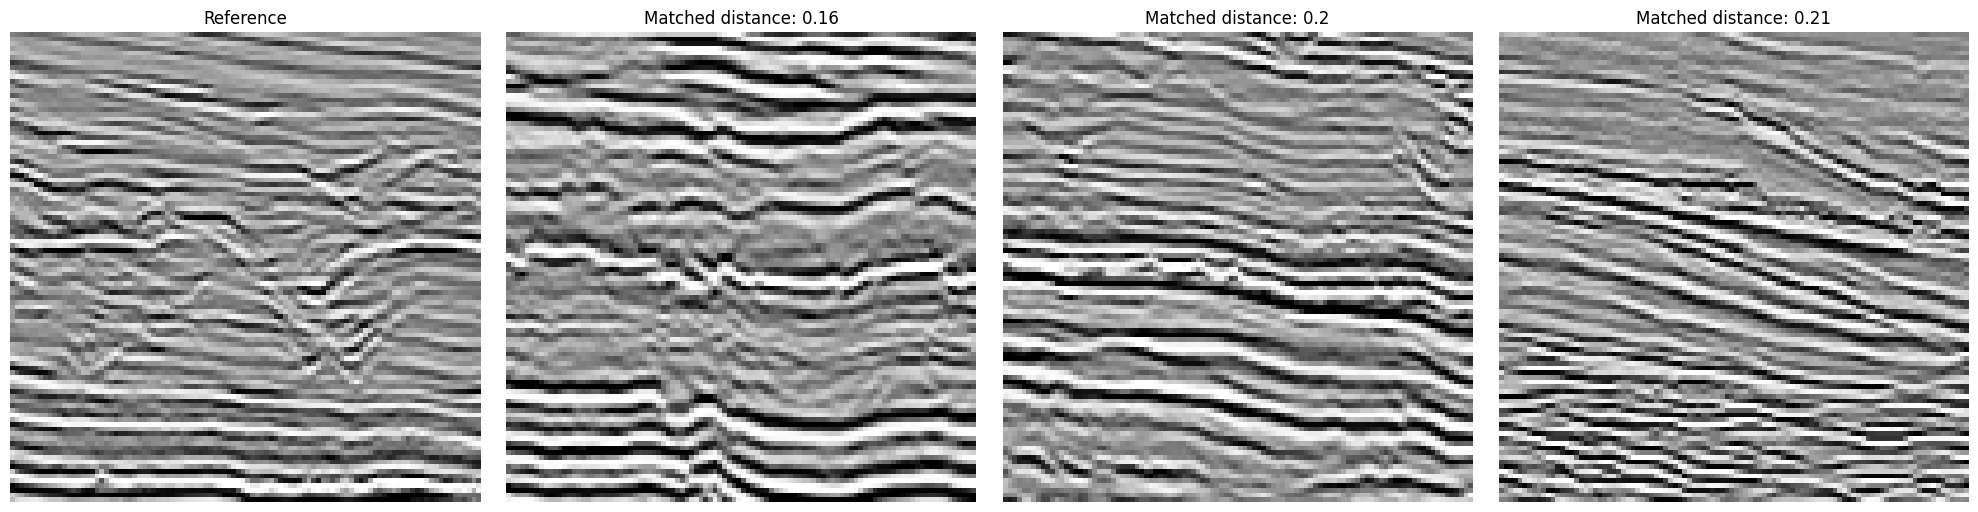

In [30]:
display_images(reference_labels, matched_labels, 3)